# SEN1721 Travel Behaviour Research

## `In-class assignment 2:`
## `Latent classs models`

**Delft University of Technology**<br>
**Q3 2025**<br>
**Instructor:** Sander van Cranenburgh<br>
**TA:**  Gabriel Nova <br>

### `Instructions`

**In-class assignments aim to:**<br>
* Illustrate how models and theory discussed in the classroom work out in practice.
* Help you gather hands-on modelling and data analysis skills.

**In-class assignments are:**<br>
* Learning environments where you work with Python and get support from TA and fellow students.
* Not graded and do not have to be submitted.

### `Use of AI tools`
AI tools, such as ChatGPT and Copilot, are great tools to assist with programming. Moreover, in your later careers, you will work in a world where such tools are widely available. As such, we **encourage** you to use AI tools **effectively**. However, be careful not to overestimate the capacity of AI tools! AI tools cannot replace you: you still have to conceptualise the problem, dissect it and structure it to conduct proper analysis. We recommend being especially **reticent** with using AI tools for the more conceptual and reflection-oriented questions. <br>

**`Learning objectives In-class assignment 2`**

After completing the in-class assignment, you will be able to:
1. Use statistical criteria to determine the number of classes in a Latent Class model
1. Parameterise the class membership function with covariates
1. Handle local maxima in the estimation of Latent Class models

#### `Import packages`

To begin, we will import all the Python libraries that we will use in this assignment.

In [2]:
# Biogeme
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme.expressions import Beta, PanelLikelihoodTrajectory

# Import custom estimation functions for Biogeme
from bio_estimation_fcns import estimate_LC, print_results

# General python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from pathlib import Path
import seaborn as sns

# Random number generator
from random import random as rand
import random
random.seed(42)

# Pandas setting to show all columns when displaying a pandas dataframe
pd.set_option('display.max_columns', None)

### `1. Load the data set` <br>

In [3]:
# Create that path to the data file
data_path =  Path(f'data/Route_choice_data.csv')

# Load the data as a pandas dataframe
df = pd.read_csv(data_path, sep=',')

**Description of variables**<br>

The data contain 3,510 stated route choices from 388 respondent. Each alternative is defined by four attributes: TT, CONG, VAR, and TC.
Below is a description of the variables in the data set. For more information about the data, you can have a look at the original paper by [Chorus et al. (2012)](https://link.springer.com/article/10.1007/s11116-012-9444-3). 


| Variable | Description                                                       | Data type                 |
|----------|-------------------------------------------------------------------|---------------------------|
| Survey   | Identifier for the survey                                         | Integer                   |
| ID       | Unique identifier for each respondent                             | Integer                   |
| Quest    | Order of the choice tasks per respondent                          | Integer                   |
| CHOICE   | Chosen alternative                                                | Integer                   |
| TT1      | Travel Time for Alternative 1                                     | Integer                   |
| CONG1    | Percentage of travel time in congestion for Alternative 1         | Integer                   |
| VAR1     | Travel time variability for Alternative 1                         | Integer                   |
| TC1      | Travel Cost for Alternative 1                                     | Float                     |
| TT2      | Travel Time for Alternative 2                                     | Integer                   |
| CONG2    | Percentage of travel time in congestion for Alternative 2         | Integer                   |
| VAR2     | Travel time variability for Alternative 2                         | Integer                   |
| TC2      | Travel Cost for Alternative 2                                     | Float                     |
| TT3      | Travel Time for Alternative 3                                     | Integer                   |
| CONG3    | Percentage of travel time in congestion for Alternative 3         | Integer                   |
| VAR3     | Travel time variability for Alternative 3                         | Integer                   |
| TC3      | Travel Cost for Alternative 3                                     | Float                     |
| AV1      | Availability of Alternative 1 (0: not available, 1: available)    | Integer                   |
| AV2      | Availability of Alternative 2 (0: not available, 1: available)    | Integer                   |
| AV3      | Availability of Alternative 3 (0: not available, 1: available)    | Integer                   |
| age      | Age of the respondent                                             | Integer                   |
| edu      | Educational level                                                 | Integer                   |
| edufin   | Max education level                                               | Integer                   |
| sex      | Gender of the respondent (e.g., male, female)                     | Integer                   |
| E1       | I considered it difficult to make choices across the presented alternatives in this choice experiment | Integer                   |
| E2       | I considered it important to make the ‘right’ choice across the presented alternatives                | Integer                   |
| E3       | When considering a new job or residential location, having a pleasant commute takes a central place in my decision | Integer      |
| E4       | In general, I think making choices is difficult                                                       | Integer                   |
| E5       | When decisions are important I consider making choices difficult                                      | Integer                   |
| E6       | When making choices, I consider the possibility that I will regret my choice in hindsight             | Integer                   |
| E7       | When making choices, I prefer a choice set that is as large as possible                               | Integer                   |

In [4]:
# As we did in in-class assignment 1, we remove respondents who did more than 9 choice tasks
df = df[df['ID'].map(df['ID'].value_counts()) <= 9]

# Create variable T for the number of choice tasks per individual
T = df['ID'].value_counts().unique()[0]
print(f"Number of choice tasks per individual: {T}") 

Number of choice tasks per individual: 9


### `2. Creating Biogeme database and variables` <br>

**`Database for panel models`** 

First, we create the biogeme database which takes into account the panel structure of the data.

In [5]:
biodata_panel = db.Database('data_panel', df) # Creates a biogeme database
biodata_panel.panel("ID")                     # Specify that the panel structure is defined by "ID"

**`Biogeme variables`**<br>
Then, we make the variables in our data set globally available so we can use them in the estimation.<br>

In [6]:
# Create biogeme variables
for c in biodata_panel.data.columns:
    if biodata_panel.data[c].dtypes != 'object': # This excludes the 'object' type columns
        globals()[c] = biodata_panel.variables[c]

### `3. Determining the optimal number of classes` <br>

Determining the number of classes in a latent class model often is a challenging task. Typically, it involves a **trade-off** between statistical performance (BIC) and behavioural interpretebility.<br><br>
To determine the optimal number of classes, we create a `for loop` to swiftly estimate LC models with an increasing numbers of classes.<br>
In the loop, we store the BIC, LL, and the estimation result object in lists for later analysis.

In [7]:
# Create empty list to store the BIC, LL, and results object
BIC = []
LL = []
lst_LC_results = []

# Set the number of classes to estimate
lst_classes = [2,3,4,5,6]

# Loop over the number of classes to estimate
for n_classes in lst_classes:
    print(f'Estimating LC model with {n_classes} classes ...')

    # Give a name to the model
    model_name = f'LC with {n_classes} classes'

    # Define the model parameters for each class
    B_tt = {}
    B_cong = {}
    B_var = {}
    B_tc = {}

    for k in range(n_classes):
        B_tt[k]    = Beta(f'B_tt_{k}',   0, None, None, 0)
        B_cong[k]  = Beta(f'B_cong_{k}', 0, None, None, 0)
        B_var[k]   = Beta(f'B_var_{k}',  0, None, None, 0)
        B_tc[k]    = Beta(f'B_tc_{k}',   0, None, None, 0)

    # Define the membership model parameters
    delta = {}
    for k in range(n_classes):  
        if k == 0: # The first class (0) is fixed to 0; 
            delta[k] = Beta(f'delta_{k}', 0, None, None, 1)
        else: # We use different random starting values for each class
            delta[k] = Beta(f'delta_{k}', rand(), None, None, 0)

    # Define the utility functions for each class
    V = [{} for _ in range(n_classes)]  # List of dictionaries for each class

    for k in range(n_classes):
        V[k] = {
            1: B_tt[k] * TT1 + B_cong[k] * CONG1 + B_var[k] * VAR1 + B_tc[k] * TC1,
            2: B_tt[k] * TT2 + B_cong[k] * CONG2 + B_var[k] * VAR2 + B_tc[k] * TC2,
            3: B_tt[k] * TT3 + B_cong[k] * CONG3 + B_var[k] * VAR3 + B_tc[k] * TC3
                }

    # Availability dictionary (same for all classes)
    AV = {1: AV1, 2: AV2, 3: AV3}  

    # Define the membership model value functions for each class
    nu = [delta[k] for k in range(n_classes)]

    # Estimate the LC model
    results_LC = estimate_LC(V,AV,nu,CHOICE,biodata_panel,model_name)

    # Store the BIC, LL values, and estimation result object in lists
    BIC.append(results_LC.get_general_statistics()['Bayesian Information Criterion'][0])
    LL.append(results_LC.get_general_statistics()['Final log likelihood'][0])
    lst_LC_results.append(results_LC)

# Create a pandas dataframe with the results (LL and BIC) for each class
df_results = pd.DataFrame({'classes': lst_classes, 'LL':LL,'BIC': BIC}).round(2)

# Show the results
df_results

Estimating LC model with 2 classes ...
Estimating LC model with 3 classes ...
Estimating LC model with 4 classes ...
Estimating LC model with 5 classes ...
Estimating LC model with 6 classes ...


,classes,LL,BIC
0,2,-2413.17,4879.94
1,3,-2362.45,4808.29
2,4,-2344.99,4803.13
3,5,-2319.83,4782.59
4,6,-2305.81,4784.34


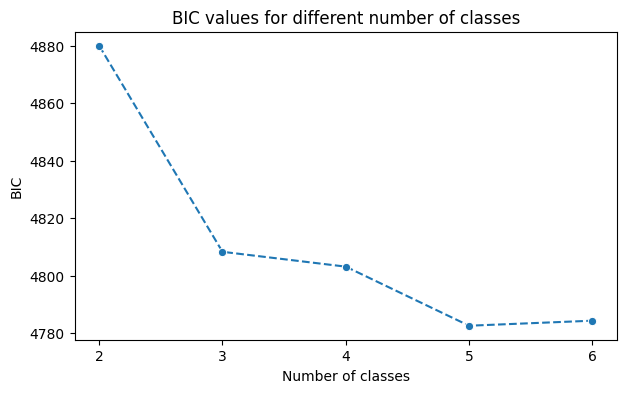

In [8]:
# Plot the BIC values as a function of the number of classes
plt.figure(figsize=(7,4))
sns.lineplot(x='classes', y='BIC', data=df_results,linestyle='dashed', marker='o')
plt.xticks(df_results['classes'].unique()) # Force x-axis ticks to be integers
plt.xlabel('Number of classes')
plt.ylabel('BIC')
plt.title('BIC values for different number of classes')
plt.show()

**Interpretation of the estimation results**

        --> The plot shows that the statistically best model (i.e. with the minimum BIC) is the model with 5 classes.

In [9]:
# Identify the index (row) with the minimum BIC value (i.e. the best statistical model)
idx = df_results.idxmin()['BIC'] 

# Print the results of the statistically best model
print_results(lst_LC_results[idx])

Results for model LC with 5 classes
Nbr of parameters:		24
Sample size:			386
Observations:			3474
Excluded data:			0
Null log likelihood:		-3816.579
Final log likelihood:		-2319.827
Likelihood ratio test (null):		2993.504
Rho square (null):			0.392
Rho bar square (null):			0.386
Akaike Information Criterion:	4687.654
Bayesian Information Criterion:	4782.594

           Value  Rob. Std err  Rob. t-test  Rob. p-value
B_cong_0 -0.0111        0.0041        -2.71          0.01
B_cong_1 -0.0423        0.0042       -10.14          0.00
B_cong_2 -0.1271        0.0202        -6.31          0.00
B_cong_3 -0.0094        0.0093        -1.01          0.31
B_cong_4 -0.0317        0.0234        -1.35          0.18
B_tc_0   -0.0455        0.0282        -1.61          0.11
B_tc_1   -0.3420        0.0257       -13.30          0.00
B_tc_2   -0.1640        0.0613        -2.68          0.01
B_tc_3   -0.1440        0.0658        -2.19          0.03
B_tc_4   -0.1569        0.0455        -3.45          0.00


**Interpretation of the estimation results**

        --> Interpreting the 5 class model is challenging. The classes are not well-separated. Moreover, the many parameters of the model are not statistically significant.

        --> Arguably, the 3-class model is the best model, considering behavioural interpretability and statistical performance. This model is more interpretable than the 5-class model. The classes are better separated, and most the parameters are statistically significant. Going from 3 to 4 classes does not improve the BIC much.

### `4. Parameterisation of the class membership function using covariates` <br>

After determining the number of classes, we can parameterise the class membership function using covariates.<br> 
In this case, we try whether respondent's education helps to explain the class membership (thus their tastes).

In [10]:
# Give a name to the model    
model_name = 'LC with 3 classes with education as covariate'

# Define the model parameters for class 0
B_tt_0    = Beta('B_tt_0',  0, None, None, 0)
B_cong_0  = Beta('B_cong_0',0, None, None, 0)
B_var_0   = Beta('B_var_0', 0, None, None, 0)
B_tc_0    = Beta('B_tc_0',  0, None, None, 0)

# Define the model parameters for class 1
B_tt_1    = Beta('B_tt_1',  0, None, None, 0)
B_cong_1  = Beta('B_cong_1',0, None, None, 0)
B_var_1   = Beta('B_var_1', 0, None, None, 0)
B_tc_1    = Beta('B_tc_1',  0, None, None, 0)

# Define the model parameters for class 2
B_tt_2    = Beta('B_tt_2',  0, None, None, 0)
B_cong_2  = Beta('B_cong_2',0, None, None, 0)
B_var_2   = Beta('B_var_2', 0, None, None, 0)
B_tc_2    = Beta('B_tc_2',  0, None, None, 0)

# Define the membership model parameters
delta_0  = Beta('delta_0', 0   , None, None, 1)
delta_1  = Beta('delta_1', 0.10, None, None, 0)
delta_2  = Beta('delta_2',-0.10, None, None, 0)
gamma_edu_1 = Beta('gamma_edu_1', 0, None, None, 0)
gamma_edu_2 = Beta('gamma_edu_2', 0, None, None, 0)

# Define the utility functions for class 0
V1_0 = B_tt_0 * TT1 + B_cong_0 * CONG1 + B_var_0 * VAR1 + B_tc_0 * TC1
V2_0 = B_tt_0 * TT2 + B_cong_0 * CONG2 + B_var_0 * VAR2 + B_tc_0 * TC2
V3_0 = B_tt_0 * TT3 + B_cong_0 * CONG3 + B_var_0 * VAR3 + B_tc_0 * TC3

# Define the utility functions for class 1
V1_1 = B_tt_1 * TT1 + B_cong_1 * CONG1 + B_var_1 * VAR1 + B_tc_1 * TC1
V2_1 = B_tt_1 * TT2 + B_cong_1 * CONG2 + B_var_1 * VAR2 + B_tc_1 * TC2
V3_1 = B_tt_1 * TT3 + B_cong_1 * CONG3 + B_var_1 * VAR3 + B_tc_1 * TC3

# Define the utility functions for class 2
V1_2 = B_tt_2 * TT1 + B_cong_2 * CONG1 + B_var_2 * VAR1 + B_tc_2 * TC1
V2_2 = B_tt_2 * TT2 + B_cong_2 * CONG2 + B_var_2 * VAR2 + B_tc_2 * TC2
V3_2 = B_tt_2 * TT3 + B_cong_2 * CONG3 + B_var_2 * VAR3 + B_tc_2 * TC3

# Associate utility functions with the numbering of alternatives in the "choice" column
V_0 = {1: V1_0, 2: V2_0, 3: V3_0}
V_1 = {1: V1_1, 2: V2_1, 3: V3_1}
V_2 = {1: V1_2, 2: V2_2, 3: V3_2}

# Put the dictionary of utility functions in a list
V = [V_0, V_1, V_2]

# Create a dictionary to describe the availability conditions of each alternative, where 1 indicates that the alternative is available, and 0 indicates that the alternative is not available.
AV = {1: AV1, 2: AV2, 3: AV3} 

# Define the membership model value functions for each class
# The term "PanelLikelihoodTrajectory(edu)**(1/T)" is a bit strange. But, it is the "trick"" to include the covariate in the membership function.
# It first multiplies the covariate over all rows in the database for each individual. Then, it takes the (1/T) to undo the multiplication. 
# The result is a the covariate for each individual at the panel level (as opposed to the observation level).
nu_0 = delta_0 # Note: one class needs to be fixed to 0. delta_0 is fixed to 0
nu_1 = delta_1 + gamma_edu_1 * PanelLikelihoodTrajectory(edu)**(1/T)
nu_2 = delta_2 + gamma_edu_2 * PanelLikelihoodTrajectory(edu)**(1/T)

# Put membership functions in a list
nu = [nu_0, nu_1, nu_2]

In [11]:
# Estimate the LC model
results_LC_edu = estimate_LC(V,AV,nu,CHOICE,biodata_panel,model_name)

# Print the results
print_results(results_LC_edu)

Results for model LC with 3 classes with education as covariate
Nbr of parameters:		16
Sample size:			386
Observations:			3474
Excluded data:			0
Null log likelihood:		-3816.579
Final log likelihood:		-2354.212
Likelihood ratio test (null):		2924.734
Rho square (null):			0.383
Rho bar square (null):			0.379
Akaike Information Criterion:	4740.424
Bayesian Information Criterion:	4803.718

              Value  Rob. Std err  Rob. t-test  Rob. p-value
B_cong_0    -0.0432        0.0047        -9.19          0.00
B_cong_1    -0.0083        0.0051        -1.63          0.10
B_cong_2    -0.0364        0.0073        -4.98          0.00
B_tc_0      -0.3447        0.0311       -11.08          0.00
B_tc_1      -0.1179        0.0261        -4.52          0.00
B_tc_2      -0.0640        0.0229        -2.79          0.01
B_tt_0      -0.0699        0.0066       -10.54          0.00
B_tt_1      -0.1626        0.0158       -10.26          0.00
B_tt_2      -0.0090        0.0056        -1.61          0.11


**Interpretation of the estimation results**

        --> The estimation results show that the education level of the respondent is a significant predictor of the class membership. The higher the education level, the less likely the respondent is to belong to class 2.

        --> In general, the covariates in LC choice models are often found to only weakly explain the class membership. However, even if the covariates are not statistically significant, the LC model still provides key behavioural insights into the taste heterogeneity in the population.

### `Exercise 1:  Testing covariates `<br>

`A.` Re-estimate the 2-class LC model using gender (i.e. sex) as a covariate<br>
`B.` Re-estimate the 2-class LC model using education as a covariate, but considering education as a binary variable: {edu<=4: "low", edu> 4: "high"}<br>
Hint: To do so, you can simply add the logical operator inside the PanelLikelihoodTrajectory(edu<=4)**(1/T) term.<br>
`C.` Compare the results (fit and estimates) of the three models with covariates (i.e. edu, sex, edu<=4). Which model is better? Why? 

In [12]:
# A) Re-estimate the 2-class LC model using gender (i.e. sex) as a covariate

# Give a name to the model    
model_name = 'LC with 3 classes with sex as covariate'

# Define the model parameters for class 0
B_tt_0    = Beta('B_tt_0',  0, None, None, 0)
B_cong_0  = Beta('B_cong_0',0, None, None, 0)
B_var_0   = Beta('B_var_0', 0, None, None, 0)
B_tc_0    = Beta('B_tc_0',  0, None, None, 0)

# Define the model parameters for class 1
B_tt_1    = Beta('B_tt_1',  0, None, None, 0)
B_cong_1  = Beta('B_cong_1',0, None, None, 0)
B_var_1   = Beta('B_var_1', 0, None, None, 0)
B_tc_1    = Beta('B_tc_1',  0, None, None, 0)

# Define the model parameters for class 2
B_tt_2    = Beta('B_tt_2',  0, None, None, 0)
B_cong_2  = Beta('B_cong_2',0, None, None, 0)
B_var_2   = Beta('B_var_2', 0, None, None, 0)
B_tc_2    = Beta('B_tc_2',  0, None, None, 0)

# Define the membership model parameters
delta_0  = Beta('delta_0', 0   , None, None, 1)
delta_1  = Beta('delta_1', 0.10, None, None, 0)
delta_2  = Beta('delta_2',-0.10, None, None, 0)
gamma_sex_1 = Beta('gamma_sex_1', 0, None, None, 0)
gamma_sex_2 = Beta('gamma_sex_2', 0, None, None, 0)

# Define the utility functions for class 0
V1_0 = B_tt_0 * TT1 + B_cong_0 * CONG1 + B_var_0 * VAR1 + B_tc_0 * TC1
V2_0 = B_tt_0 * TT2 + B_cong_0 * CONG2 + B_var_0 * VAR2 + B_tc_0 * TC2
V3_0 = B_tt_0 * TT3 + B_cong_0 * CONG3 + B_var_0 * VAR3 + B_tc_0 * TC3

# Define the utility functions for class 1
V1_1 = B_tt_1 * TT1 + B_cong_1 * CONG1 + B_var_1 * VAR1 + B_tc_1 * TC1
V2_1 = B_tt_1 * TT2 + B_cong_1 * CONG2 + B_var_1 * VAR2 + B_tc_1 * TC2
V3_1 = B_tt_1 * TT3 + B_cong_1 * CONG3 + B_var_1 * VAR3 + B_tc_1 * TC3

# Define the utility functions for class 2
V1_2 = B_tt_2 * TT1 + B_cong_2 * CONG1 + B_var_2 * VAR1 + B_tc_2 * TC1
V2_2 = B_tt_2 * TT2 + B_cong_2 * CONG2 + B_var_2 * VAR2 + B_tc_2 * TC2
V3_2 = B_tt_2 * TT3 + B_cong_2 * CONG3 + B_var_2 * VAR3 + B_tc_2 * TC3

# Associate utility functions with the numbering of alternatives in the "choice" column
V_0 = {1: V1_0, 2: V2_0, 3: V3_0}
V_1 = {1: V1_1, 2: V2_1, 3: V3_1}
V_2 = {1: V1_2, 2: V2_2, 3: V3_2}

# Put the dictionary of utility functions in a list
V = [V_0, V_1, V_2]

# Create a dictionary to describe the availability conditions of each alternative, where 1 indicates that the alternative is available, and 0 indicates that the alternative is not available.
AV = {1: AV1, 2: AV2, 3: AV3} 

# Define the membership model value functions for each class
# The term "PanelLikelihoodTrajectory(edu)**(1/T)" is a bit strange. But, it is the "trick"" to include the covariate in the membership function.
# It first multiplies the covariate over all rows in the database for each individual. Then, it takes the (1/T) to undo the multiplication. 
# The result is a the covariate for each individual at the panel level (as opposed to the observation level).
nu_0 = delta_0 # Note: one class needs to be fixed to 0. delta_0 is fixed to 0
nu_1 = delta_1 + gamma_sex_1 * PanelLikelihoodTrajectory(sex)**(1/T)
nu_2 = delta_2 + gamma_sex_2 * PanelLikelihoodTrajectory(sex)**(1/T)

# Put membership functions in a list
nu = [nu_0, nu_1, nu_2]

# Estimate the LC model
results_LC_sex = estimate_LC(V,AV,nu,CHOICE,biodata_panel,model_name)

# Print the results
print_results(results_LC_sex)

Results for model LC with 3 classes with sex as covariate
Nbr of parameters:		16
Sample size:			386
Observations:			3474
Excluded data:			0
Null log likelihood:		-3816.579
Final log likelihood:		-2360.867
Likelihood ratio test (null):		2911.424
Rho square (null):			0.381
Rho bar square (null):			0.377
Akaike Information Criterion:	4753.734
Bayesian Information Criterion:	4817.027

              Value  Rob. Std err  Rob. t-test  Rob. p-value
B_cong_0    -0.0428        0.0047        -9.04          0.00
B_cong_1    -0.0090        0.0052        -1.73          0.08
B_cong_2    -0.0372        0.0067        -5.53          0.00
B_tc_0      -0.3567        0.0330       -10.80          0.00
B_tc_1      -0.1144        0.0261        -4.39          0.00
B_tc_2      -0.0742        0.0207        -3.58          0.00
B_tt_0      -0.0732        0.0060       -12.18          0.00
B_tt_1      -0.1621        0.0160       -10.16          0.00
B_tt_2      -0.0102        0.0060        -1.70          0.09
B_var_

In [13]:
# B) Re-estimate the 2-class LC model using education as a covariate, but considering education as a binary variable

# Give a name to the model    
model_name = 'LC with 3 classes with education as a binary as covariate'

# Define the model parameters for class 0
B_tt_0    = Beta('B_tt_0',  0, None, None, 0)
B_cong_0  = Beta('B_cong_0',0, None, None, 0)
B_var_0   = Beta('B_var_0', 0, None, None, 0)
B_tc_0    = Beta('B_tc_0',  0, None, None, 0)

# Define the model parameters for class 1
B_tt_1    = Beta('B_tt_1',  0, None, None, 0)
B_cong_1  = Beta('B_cong_1',0, None, None, 0)
B_var_1   = Beta('B_var_1', 0, None, None, 0)
B_tc_1    = Beta('B_tc_1',  0, None, None, 0)

# Define the model parameters for class 2
B_tt_2    = Beta('B_tt_2',  0, None, None, 0)
B_cong_2  = Beta('B_cong_2',0, None, None, 0)
B_var_2   = Beta('B_var_2', 0, None, None, 0)
B_tc_2    = Beta('B_tc_2',  0, None, None, 0)

# Define the membership model parameters
delta_0  = Beta('delta_0', 0   , None, None, 1)
delta_1  = Beta('delta_1', 0.10, None, None, 0)
delta_2  = Beta('delta_2',-0.10, None, None, 0)
gamma_edulow_1 = Beta('gammalow_edu_1', 0, None, None, 0)
gamma_edulow_2 = Beta('gammalow_edu_2', 0, None, None, 0)

# Define the utility functions for class 0
V1_0 = B_tt_0 * TT1 + B_cong_0 * CONG1 + B_var_0 * VAR1 + B_tc_0 * TC1
V2_0 = B_tt_0 * TT2 + B_cong_0 * CONG2 + B_var_0 * VAR2 + B_tc_0 * TC2
V3_0 = B_tt_0 * TT3 + B_cong_0 * CONG3 + B_var_0 * VAR3 + B_tc_0 * TC3

# Define the utility functions for class 1
V1_1 = B_tt_1 * TT1 + B_cong_1 * CONG1 + B_var_1 * VAR1 + B_tc_1 * TC1
V2_1 = B_tt_1 * TT2 + B_cong_1 * CONG2 + B_var_1 * VAR2 + B_tc_1 * TC2
V3_1 = B_tt_1 * TT3 + B_cong_1 * CONG3 + B_var_1 * VAR3 + B_tc_1 * TC3

# Define the utility functions for class 2
V1_2 = B_tt_2 * TT1 + B_cong_2 * CONG1 + B_var_2 * VAR1 + B_tc_2 * TC1
V2_2 = B_tt_2 * TT2 + B_cong_2 * CONG2 + B_var_2 * VAR2 + B_tc_2 * TC2
V3_2 = B_tt_2 * TT3 + B_cong_2 * CONG3 + B_var_2 * VAR3 + B_tc_2 * TC3

# Associate utility functions with the numbering of alternatives in the "choice" column
V_0 = {1: V1_0, 2: V2_0, 3: V3_0}
V_1 = {1: V1_1, 2: V2_1, 3: V3_1}
V_2 = {1: V1_2, 2: V2_2, 3: V3_2}

# Put the dictionary of utility functions in a list
V = [V_0, V_1, V_2]

# Create a dictionary to describe the availability conditions of each alternative, where 1 indicates that the alternative is available, and 0 indicates that the alternative is not available.
AV = {1: AV1, 2: AV2, 3: AV3} 

# Define the membership model value functions for each class
# The term "PanelLikelihoodTrajectory(edu)**(1/T)" is a bit strange. But, it is the "trick"" to include the covariate in the membership function.
# It first multiplies the covariate over all rows in the database for each individual. Then, it takes the (1/T) to undo the multiplication. 
# The result is a the covariate for each individual at the panel level (as opposed to the observation level).
nu_0 = delta_0 # Note: one class needs to be fixed to 0. delta_0 is fixed to 0
nu_1 = delta_1 + gamma_edulow_1 * PanelLikelihoodTrajectory(edu<=4)**(1/T)
nu_2 = delta_2 + gamma_edulow_2 * PanelLikelihoodTrajectory(edu<=4)**(1/T)

# Put membership functions in a list
nu = [nu_0, nu_1, nu_2]

# Estimate the LC model
results_LC_edulow = estimate_LC(V,AV,nu,CHOICE,biodata_panel,model_name)

# Print the results
print_results(results_LC_edulow)

Results for model LC with 3 classes with education as a binary as covariate
Nbr of parameters:		16
Sample size:			386
Observations:			3474
Excluded data:			0
Null log likelihood:		-3816.579
Final log likelihood:		-2358.651
Likelihood ratio test (null):		2915.857
Rho square (null):			0.382
Rho bar square (null):			0.378
Akaike Information Criterion:	4749.302
Bayesian Information Criterion:	4812.595

                 Value  Rob. Std err  Rob. t-test  Rob. p-value
B_cong_0       -0.0430        0.0047        -9.22          0.00
B_cong_1       -0.0085        0.0051        -1.65          0.10
B_cong_2       -0.0369        0.0070        -5.27          0.00
B_tc_0         -0.3505        0.0327       -10.72          0.00
B_tc_1         -0.1172        0.0260        -4.50          0.00
B_tc_2         -0.0692        0.0236        -2.93          0.00
B_tt_0         -0.0714        0.0068       -10.55          0.00
B_tt_1         -0.1624        0.0156       -10.38          0.00
B_tt_2         -0.0097

In [14]:
# C) Compare the results (fit and estimates) of the three models with covariates (i.e. edu, sex, edu<=2). Which model is better? Why? 
print(f" LL 2-class LC edu:    {np.round(results_LC_edu.get_general_statistics()['Final log likelihood'][0],2)}")
print(f" LL 2-class LC sex:    {np.round(results_LC_sex.get_general_statistics()['Final log likelihood'][0],2)}")
print(f" LL 2-class LC edulow: {np.round(results_LC_edulow.get_general_statistics()['Final log likelihood'][0],2)}")

# The LC with model edu as an ordinal variable has the highest log-likelihood value, which indicates that it is the best model among the three. 
# Also, this model is the only model where the covariate is significant.

 LL 2-class LC edu:    -2354.21
 LL 2-class LC sex:    -2360.87
 LL 2-class LC edulow: -2358.65


### `5. Exploring robustness and convergence stability` <br>
The log-likelihood function is a mathematical function that represents the log of the probability of observing the given data under a specific statistical model, as a function of the model parameters. It is used to estimate the parameters of the choice model that are most likely to have produced the observed data.
<br><br>
However, when estimation a choice model, the estimation algorithm may get stuck in **local** maxima. This happens if the likelihood function of the model is not **globally concave**. Local maxima are solutions where the function reaches a high value but not the highest possible. In contrast, a global maximum refers to the highest value of the function across its entire domain. In case, an optimisation algorithm gets stuck in a local solution, it does not recover the true maximum likelihood estimates. Such estimates are thus biased are should never be used for policy making. Hence, choice modellers should be aware of the possibility that optimisation algorithms can get stuck in local solutions. Unfortunately, getting stuck in local solutions is a common issue with the estimation of LC choice models. 
<br><br>
One strategy to deal with local maxima is to try different starting points. Below, we estimate the 2-class LC model using 20 different starting points. Specifically, we use a random stanrting point between -1 and 0 for all parameters, using the rand() function. Furthermore, we set the seed number for each ran to a different value, to ensure that the starting points are different (and reproducible). One can never be sure that the estimated parameters are the global maximum, but by trying different starting points, one can increase the likelihood of finding the global maximum.

In [15]:
# Create empty list to store the LL, run, and results object
LL = []
run = []
lst_LC_results = []

# Set the number of runs
N_runs = 25
print(f"Starting estimation of {N_runs} runs ...")
for i in range(1,N_runs+1):
    
    # Set the seed for the random number generator
    random.seed(i)

    # Give a name to the model    
    model_name = 'LC with 2 classes, run ' + str(i)

    # Define the model parameters for class 0
    B_tt_0    = Beta('B_tt_0',  -rand(), None, None, 0)
    B_cong_0  = Beta('B_cong_0',-rand(), None, None, 0)
    B_var_0   = Beta('B_var_0', -rand(), None, None, 0)
    B_tc_0    = Beta('B_tc_0',  -rand(), None, None, 0)

    # Define the utility functions for class 1
    B_tt_1    = Beta('B_tt_1',  -rand(), None, None, 0)
    B_cong_1  = Beta('B_cong_1',-rand(), None, None, 0)
    B_var_1   = Beta('B_var_1', -rand(), None, None, 0)
    B_tc_1    = Beta('B_tc_1',  -rand(), None, None, 0)

    # Define the membership model parameters
    delta_0 = Beta('delta_0',  0,       None, None, 1)
    delta_1 = Beta('delta_1',  -rand(), None, None, 0)
    
    # Define the utility functions for class 0
    V1_0 = B_tt_0 * TT1 + B_cong_0 * CONG1 + B_var_0 * VAR1 + B_tc_0 * TC1
    V2_0 = B_tt_0 * TT2 + B_cong_0 * CONG2 + B_var_0 * VAR2 + B_tc_0 * TC2
    V3_0 = B_tt_0 * TT3 + B_cong_0 * CONG3 + B_var_0 * VAR3 + B_tc_0 * TC3

    # Define the utility functions for class 1
    V1_1 = B_tt_1 * TT1 + B_cong_1 * CONG1 + B_var_1 * VAR1 + B_tc_1 * TC1
    V2_1 = B_tt_1 * TT2 + B_cong_1 * CONG2 + B_var_1 * VAR2 + B_tc_1 * TC2
    V3_1 = B_tt_1 * TT3 + B_cong_1 * CONG3 + B_var_1 * VAR3 + B_tc_1 * TC3

    # Create a dictionary associating utility functions with the numbering of alternatives in the "choice" column
    V_0 = {1: V1_0, 2: V2_0, 3: V3_0}
    V_1 = {1: V1_1, 2: V2_1, 3: V3_1}

    # Put the dictionaries of utility functions in a list
    V = [V_0, V_1]

    # Create a dictionary to describe the availability conditions of each alternative, where 1 indicates that the alternative is available, and 0 indicates that the alternative is not available.
    AV = {1: AV1, 2: AV2, 3: AV3} 

    # Define the membership model value functions for each class
    nu_0 = delta_0 # Note: one class needs to be fixed to 0. delta_0 is fixed to 0
    nu_1 = delta_1

    # Put membership functions in a list
    nu = [nu_0, nu_1]

    # Estimate the LC model
    results_LC = estimate_LC(V,AV,nu,CHOICE,biodata_panel,model_name)

    # Get the log-likelihood value  
    ll = results_LC.get_general_statistics()['Final log likelihood'][0]

    # Store the BIC and LL values in lists
    LL.append(ll)
    run.append(i)
    lst_LC_results.append(results_LC)
    
    # Print the progress
    print(f'Run {i:2d}/{N_runs}\t LL = {np.round(ll,3)}')

df_runs = pd.DataFrame({'run': run, 'LL':LL}).round(3)

Starting estimation of 25 runs ...
Run  1/25	 LL = -2555.575
Run  2/25	 LL = -2413.167
Run  3/25	 LL = -2413.167
Run  4/25	 LL = -2413.167
Run  5/25	 LL = -2413.167
Run  6/25	 LL = -2425.704
Run  7/25	 LL = -2413.167
Run  8/25	 LL = -2574.499
Run  9/25	 LL = -2467.146
Run 10/25	 LL = -2558.124
Run 11/25	 LL = -2467.147
Run 12/25	 LL = -2425.704
Run 13/25	 LL = -2556.863
Run 14/25	 LL = -2558.132
Run 15/25	 LL = -2413.167
Run 16/25	 LL = -2413.167
Run 17/25	 LL = -2413.167
Run 18/25	 LL = -2413.167
Run 19/25	 LL = -2413.167
Run 20/25	 LL = -2425.704
Run 21/25	 LL = -2413.167
Run 22/25	 LL = -2442.986
Run 23/25	 LL = -2571.94
Run 24/25	 LL = -2442.986
Run 25/25	 LL = -2413.167


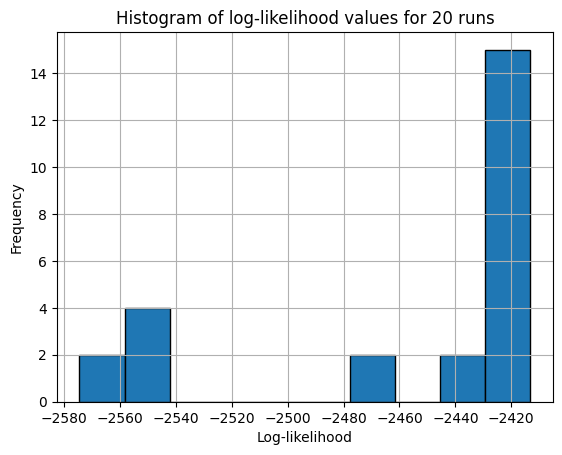

In [16]:
# Plot the histogram of the log-likelihood values
df_runs.hist(column='LL', bins=10, edgecolor='black', linewidth=1)
plt.xlabel('Log-likelihood')
plt.ylabel('Frequency')
plt.title('Histogram of log-likelihood values for 20 runs')
plt.show()

**Interpretation**<br>

        --> The histogram shows that a substantial share of the estimation end up in a local maxima. The best known solution (and probably the global maximum) is the model with LL = -2413.167
        
        --> The implication of the existance of local maxima is that we need to estimate the model multiple times with different starting points to increase the likelihood of finding the global maximum.

        --> Using good starting points is also helpful to avoid local maxima. In this case, we used negative starting points because we expect all marginal utilities (betas) to be negative. However, the starting points were probably too large (-1,0) as the betas in this model were found to be considerably smaller.

### `Exercise 2:  Investigating parameter stability `<br>

`A.` Investigate the parameter stability. To do so, <br>
1. Put all the results in a dataframe, using `df_beta_values = pd.DataFrame([lst_LC_results[i].get_beta_values() for i in range(N_runs)])` <br>
2. Show the results in a boxplot using `sns.boxplot(data=df_beta_values.iloc[:,:-1], showfliers=False)`. Try turning on and off the showfliers option to see the full distribution of the estimates. Are the estimates stable across the different runs? <br>

`B.` Investigate the parameter stability of the "good runs". To do so,  <br>
1. Add the Log-likelihoods to the dataframe, using `df_beta_values_LL = pd.concat((df_runs,df_beta_values), axis = 1)`<br>
2. Keep only the results with the LL of the best known solution (with a small margin), using `df_beta_values_opt = df_beta_values_LL[df_beta_values_LL['LL'] > -2414]`<br>
3. Carefully inspect df_beta_values_opt. Do you see a symmetry in the estimations? Explain why this symmetry occurs. <br>
4. Are the estimates stable across these runs? <br>


In [17]:
# A) Investigate the parameter stability
# 1. Put all the results in a dataframe
df_beta_values = pd.DataFrame([lst_LC_results[i].get_beta_values() for i in range(N_runs)])
df_beta_values

,B_cong_0,B_cong_1,B_tc_0,B_tc_1,B_tt_0,B_tt_1,B_var_0,B_var_1,delta_1
0,-0.850073,-0.025378,-0.089342,-0.181534,-7.943401e-09,-0.069576,-0.598262,-0.031815,3.632948
1,-0.039168,-0.008301,-0.216571,-0.128857,-4.388297e-02,-0.169124,-0.026344,-0.081179,-0.717612
2,-0.008312,-0.039175,-0.128850,-0.216597,-1.689914e-01,-0.043874,-0.081086,-0.026342,0.716962
3,-0.039168,-0.008304,-0.216573,-0.128805,-4.388286e-02,-0.169123,-0.026344,-0.081182,-0.717552
4,-0.039167,-0.008303,-0.216569,-0.128846,-4.388457e-02,-0.169151,-0.026345,-0.081197,-0.717713
5,-0.005332,-0.035285,-0.108633,-0.203984,-1.299821e+00,-0.049901,-0.928003,-0.027132,1.175720
6,-0.039172,-0.008295,-0.216586,-0.128899,-4.387627e-02,-0.169066,-0.026343,-0.081143,-0.717180
7,0.306158,-0.027646,-1.599709,-0.174711,9.211879e-01,-0.067689,-0.024674,-0.032255,5.698053
8,-0.033512,0.352714,-0.194366,-0.166062,-5.628756e-02,-0.604904,-0.035275,-0.090017,-1.774564
9,-0.026045,-3.081856,-0.179044,-0.050096,-6.868272e-02,0.211165,-0.032684,2.184573,-4.137130


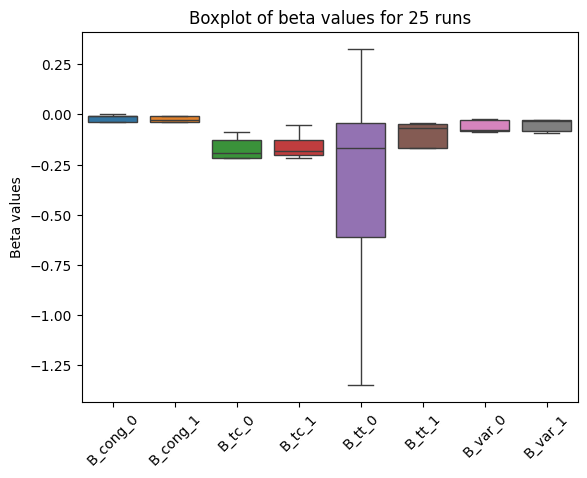

In [18]:
# A) Investigate the parameter stability
# 2. Show the results in a boxplot
sns.boxplot(data=df_beta_values.iloc[:,:-1], showfliers=False)
plt.xticks(rotation=45)
plt.ylabel('Beta values')
plt.title(f'Boxplot of beta values for {N_runs} runs')
plt.show()

In [19]:
# B) Investigate the parameter stability of the "good runs"
# 1. Add the Log-likelihoods to the dataframe
df_beta_values_LL = pd.concat((df_runs,df_beta_values), axis = 1)
df_beta_values_LL

,run,LL,B_cong_0,B_cong_1,B_tc_0,B_tc_1,B_tt_0,B_tt_1,B_var_0,B_var_1,delta_1
0,1,-2555.575,-0.850073,-0.025378,-0.089342,-0.181534,-7.943401e-09,-0.069576,-0.598262,-0.031815,3.632948
1,2,-2413.167,-0.039168,-0.008301,-0.216571,-0.128857,-4.388297e-02,-0.169124,-0.026344,-0.081179,-0.717612
2,3,-2413.167,-0.008312,-0.039175,-0.128850,-0.216597,-1.689914e-01,-0.043874,-0.081086,-0.026342,0.716962
3,4,-2413.167,-0.039168,-0.008304,-0.216573,-0.128805,-4.388286e-02,-0.169123,-0.026344,-0.081182,-0.717552
4,5,-2413.167,-0.039167,-0.008303,-0.216569,-0.128846,-4.388457e-02,-0.169151,-0.026345,-0.081197,-0.717713
5,6,-2425.704,-0.005332,-0.035285,-0.108633,-0.203984,-1.299821e+00,-0.049901,-0.928003,-0.027132,1.175720
6,7,-2413.167,-0.039172,-0.008295,-0.216586,-0.128899,-4.387627e-02,-0.169066,-0.026343,-0.081143,-0.717180
7,8,-2574.499,0.306158,-0.027646,-1.599709,-0.174711,9.211879e-01,-0.067689,-0.024674,-0.032255,5.698053
8,9,-2467.146,-0.033512,0.352714,-0.194366,-0.166062,-5.628756e-02,-0.604904,-0.035275,-0.090017,-1.774564
9,10,-2558.124,-0.026045,-3.081856,-0.179044,-0.050096,-6.868272e-02,0.211165,-0.032684,2.184573,-4.137130


In [20]:
# B) Investigate the parameter stability of the "good runs"
# 2. Keep only the results with the LL of the best known solution
df_beta_values_opt = df_beta_values_LL[df_beta_values_LL['LL'] > -2414]
df_beta_values_opt

,run,LL,B_cong_0,B_cong_1,B_tc_0,B_tc_1,B_tt_0,B_tt_1,B_var_0,B_var_1,delta_1
1,2,-2413.167,-0.039168,-0.008301,-0.216571,-0.128857,-0.043883,-0.169124,-0.026344,-0.081179,-0.717612
2,3,-2413.167,-0.008312,-0.039175,-0.128850,-0.216597,-0.168991,-0.043874,-0.081086,-0.026342,0.716962
3,4,-2413.167,-0.039168,-0.008304,-0.216573,-0.128805,-0.043883,-0.169123,-0.026344,-0.081182,-0.717552
4,5,-2413.167,-0.039167,-0.008303,-0.216569,-0.128846,-0.043885,-0.169151,-0.026345,-0.081197,-0.717713
6,7,-2413.167,-0.039172,-0.008295,-0.216586,-0.128899,-0.043876,-0.169066,-0.026343,-0.081143,-0.717180
14,15,-2413.167,-0.039168,-0.008304,-0.216571,-0.128837,-0.043884,-0.169147,-0.026345,-0.081196,-0.717668
15,16,-2413.167,-0.008305,-0.039167,-0.128828,-0.216570,-0.169138,-0.043884,-0.081190,-0.026345,0.717686
16,17,-2413.167,-0.039170,-0.008305,-0.216578,-0.128675,-0.043878,-0.169025,-0.026343,-0.081142,-0.717219
17,18,-2413.167,-0.039172,-0.008306,-0.216585,-0.128797,-0.043878,-0.169052,-0.026343,-0.081134,-0.717243
18,19,-2413.167,-0.008317,-0.039175,-0.128709,-0.216595,-0.168967,-0.043873,-0.081088,-0.026342,0.716913


In [21]:
# B) Investigate the parameter stability of the "good runs"
# 3.
# We observe that the estimates are fully symmetric across the classes. This is expected since the classes are randomly assigned.
# Apart from the symmetry, the estimates are all the same. This implies that the the results are stable across the runs.

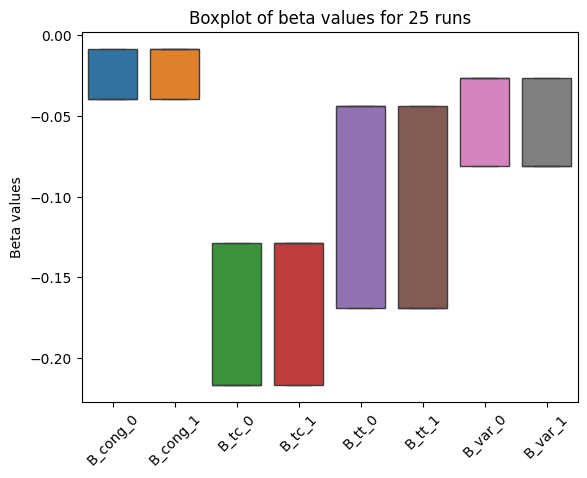

In [23]:
sns.boxplot(data=df_beta_values_opt.iloc[:,2:-1], showfliers=False)
plt.xticks(rotation=45)
plt.ylabel('Beta values')
plt.title(f'Boxplot of beta values for {N_runs} runs')
plt.show()